## Machine learning critical temperature of superconductors

Classification of high-$T_c$ superconductors from the low-$T_c$ superconductors and regression prediction of critical temperature.

### Random Forest Model

*Author: Rabindra Nepal*

*Email: rnepal2@unl.edu*

In [518]:
# Dependencies
import os, math, time
import numpy as np
import pandas as pd
import random
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.utils.random import sample_without_replacement

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

**Dataset**

Superconductivty Dataset 

https://archive.ics.uci.edu/ml/datasets/Superconductivty+Data

National Institue of Materials Science (Superconducting Material Database (SuperCon))

https://supercon.nims.go.jp/index_en.html

In [519]:
df = pd.read_csv('./data/train.csv')
unique_materials = pd.read_csv('./data/unique_m.csv')

In [520]:
unique_materials.head()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


In [521]:
df.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


#### Grouping the materials into three groups (Feature engineering from unique_materials dataset)

We divide the total material information provided into three subgroups. For that we first add three different features into the dataset based on the different materials information dataset.

1. Fe-based: Fe-based superconducting materials
2. Cu-based: Cu-based (Cuprates) superconducting materials
3. Rest of the materials except Fe-based and Cu-based

In [522]:
# not Fe or Cu based superconductors
def other_class(unique_materials):
    other_class = []
    for f, c in zip(unique_materials.Fe.values, unique_materials.Cu.values):
        if f == 0.0 and c == 0.0:
            other_class.append(1.0)
        else:
            other_class.append(0.0)
    return np.array(other_class)

In [523]:
# adding some new columns in df
df['material'] = unique_materials.material
df['Fe'] = unique_materials.Fe
df['Cu'] = unique_materials.Cu
df['Other'] = other_class(unique_materials)

In [524]:
category_values = []
for f, c, o in zip(df.Fe.values, df.Cu.values, df.Other.values):
    if f != 0:
        category_values.append("Fe-based")
    elif c != 0:
        category_values.append("Cu-based")
    else:
        category_values.append("Other")
df['category'] = np.array(category_values)

In [525]:
# shuffling
df = shuffle(df)

**Data preparation**

We will keep DataFrame df here as the original dataset and prepare the dataset for each of the modelling using this df separately followed by the necessary data preprocessing

### Random forest classification

#### Determination of critical temperature

A classification model to separate the superconducting materials into two groups: low-T_c and high-T_c superconductors. We will first search for the best critical temeperature and build the best performing classifier. 

In [527]:
y = df.critical_temp
X = df.drop(columns=['material', 'Fe', 'Cu', 'Other', 'category' , 'critical_temp'], inplace=False)

**Features scaling**

In [503]:
# scaling 
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

C:\Users\nepal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\nepal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [504]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Principle component analysis (PCA)**

Due to the presence of many collinear features in the dataset, PCA is done by selecting the number of principle components to maintian 95% variance in the dataset. 

*Since we are carrying out the PCA, we will use maximum of all the features in the random forest max_features parameter later by setting max_features = None.*

In [505]:
pca = PCA(n_components=16)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [506]:
pca.explained_variance_ratio_.sum()

0.948279478493303

In [507]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Let us look into the performance of the classification model using different temperature that separates the two groups of the superconductors - critical temperature.

In [508]:
def random_forest_tsep(X_train, y_train, X_test, y_test, T_sep):
    # T_sep classification
    y_train = (y_train < T_sep).astype(np.int)
    y_test = (y_test < T_sep).astype(np.int)

    clf = RandomForestClassifier(n_estimators=120, max_depth=19, max_features=None)
    clf.fit(X_train, y_train)
    
    # prediction on test data
    y_pred = clf.predict(X_test)
    
    return {"accuracy": accuracy_score(y_test, y_pred), "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred), "f1-score": f1_score(y_test, y_pred)}

# performance score vs T_sep 
def separature_temp_curve(X_train, y_train, X_test, y_test):
    out_metrics = {}
    for T_sep in np.linspace(1, 45, 10):
        out = random_forest_tsep(X_train, y_train, X_test, y_test, T_sep)
        for key in out.keys():
            if key not in out_metrics.keys():
                out_metrics[key] = [out[key]]
            else:
                out_metrics[key].append(out[key])
    return out_metrics

In [509]:
outs = separature_temp_curve(X_train_pca, y_train, X_test_pca, y_test)

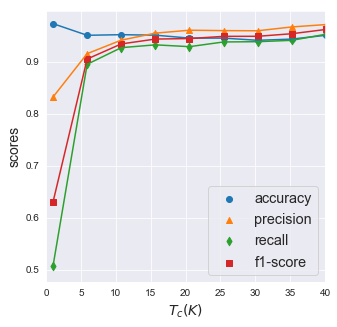

In [510]:
# plotting the performance scores vs T_sep
fig = plt.figure(figsize=(5, 5))
plt.plot(np.linspace(1, 45, 10), outs['accuracy'])
plt.scatter(np.linspace(1, 45, 10), outs['accuracy'], label='accuracy')

plt.plot(np.linspace(1, 45, 10), outs['precision'])
plt.scatter(np.linspace(1, 45, 10), outs['precision'], label='precision', marker='^');

plt.plot(np.linspace(1, 45, 10), outs['recall'])
plt.scatter(np.linspace(1, 45, 10), outs['recall'], label='recall', marker='d');

plt.plot(np.linspace(1, 45, 10), outs['f1-score'])
plt.scatter(np.linspace(1, 45, 10), outs['f1-score'], label='f1-score', marker='s');
plt.legend(fontsize='x-large');
plt.xlim(0, 40)
plt.ylabel('scores', fontsize=14)
plt.xlabel('$T_c(K)$', fontsize=14);
plt.savefig("critical_temp_curve.pdf");

#### Model performance with training size

In [511]:
y = df.critical_temp
X = df.drop(columns=['material', 'Fe', 'Cu', 'Other', 'category' , 'critical_temp'], inplace=False)

In [512]:
# scaling 
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

C:\Users\nepal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\nepal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [513]:
# helper function: returns full dataset with PCA without splitting train_test_split
def full_dataset(X, y):
    pca = PCA(n_components=16)
    pca.fit(X)
    Xpca = pca.transform(X)
    return Xpca, y

In [514]:
X, y0 = full_dataset(X, y)
# critical temperature = 10K
T_sep = 10
y = (y0 < T_sep).astype(np.int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

Note that we will train the model with training set at different size of it and test the model with distinct set of test dataset.

The performance of the model vs the size of the training dataset

In [515]:
# carries out random forest prediction and returns result metrics
def random_forest_training_size(X_train, X_test, y_train, y_test):
    # model
    clf = RandomForestClassifier(n_estimators=120, max_depth=19, max_features=None)
    # prediction
    clf.fit(X_train, y_train)
    
    # prediction on test data
    y_pred = clf.predict(X_test)
    
    return {"accuracy": accuracy_score(y_test, y_pred), "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred), "f1-score": f1_score(y_test, y_pred)}

# performance score vs training size
def training_size_curve(X_train, X_test, y_train, y_test):
    out_metrics = {}    
    length = len(X_train) - 1
    # including higher number of points for 0 t0 0.25*length of the dataset
    train_sizes = list(np.linspace(5, 0.20*length, 10))
    train_sizes = [int(val) for val in train_sizes]
    for val in np.linspace(0.225*length, length-1, 10):
        train_sizes.append(int(val))
    # for each train size
    for train_size in train_sizes:
        indices = sample_without_replacement(length, train_size)
        Xs, ys = X_train[indices], y_train[indices]
        out = random_forest_training_size(Xs, X_test, ys, y_test)
        for key in out.keys():
            if key not in out_metrics.keys():
                out_metrics[key] = [out[key]]
            else:
                out_metrics[key].append(out[key])
    return out_metrics, train_sizes

In [516]:
outs, train_sizes = training_size_curve(X_train, X_test, y_train.values, y_test.values)

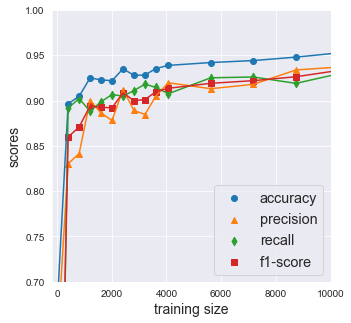

In [517]:
sns.set_style("darkgrid")
fig = plt.figure(figsize=(5, 5))
plt.plot(train_sizes, outs['accuracy'])
plt.scatter(train_sizes, outs['accuracy'], label='accuracy')

plt.plot(train_sizes, outs['precision'])
plt.scatter(train_sizes, outs['precision'], label='precision', marker='^');

plt.plot(train_sizes, outs['recall'])
plt.scatter(train_sizes, outs['recall'], label='recall', marker='d');

plt.plot(train_sizes, outs['f1-score'])
plt.scatter(train_sizes, outs['f1-score'], label='f1-score', marker='s');
plt.legend(fontsize='x-large');
plt.ylabel('scores', fontsize=14)
plt.xlabel('training size', fontsize=14);
plt.xlim(-200, 10000);
plt.ylim(0.7, 1.0);
plt.savefig("training_size_curve.pdf");

**Best classification model**

Finding the best model hyperparameters with GridSearch and cross-validation. Then we create the classification model with best parameters.

In [215]:
clf = RandomForestClassifier()

In [216]:
params_grid = {"n_estimators": [100, 120, 140], "max_depth": [17, 19, 21], "max_features": None}

# max_features = None => max_features = n_features
# Since we have reduced the features dimensions through PCA, we want to use all the features left
# at max for the further calculations

In [217]:
clf_cv = GridSearchCV(clf, params_grid, cv=5)

In [218]:
clf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 120, 140], 'max_depth': [17, 19, 21]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [219]:
clf_cv.best_params_

{'max_depth': 21, 'n_estimators': 120}

In [221]:
model = RandomForestClassifier(n_estimators=120, max_depth=21)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=21, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [222]:
y_test_pred = model.predict(X_test)

In [223]:
print('precision: ', precision_score(y_test, y_test_pred))
print('recall: ', recall_score(y_test, y_test_pred))
print('f1-score: ', f1_score(y_test, y_test_pred))

confusion_matrix(y_test, y_test_pred)

precision:  0.9410138248847926
recall:  0.9165170556552962
f1-score:  0.9286039108685766


array([[2012,   64],
       [  93, 1021]], dtype=int64)

In [224]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2076
           1       0.94      0.92      0.93      1114

   micro avg       0.95      0.95      0.95      3190
   macro avg       0.95      0.94      0.95      3190
weighted avg       0.95      0.95      0.95      3190



## Regression Models

Regression models to predict the critical temperature of superconduting materials

In [219]:
# helper function: returns entire dataset with PCA
def full_pca_dataset(X, y):
    pca = PCA(n_components=16)
    pca.fit(X)
    Xpca = pca.transform(X)
    return Xpca, y

In [220]:
Xpca, y = full_dataset(X, y)

In [221]:
X_train, X_test, y_train, y_test = train_test_split(Xpca, y, test_size=0.15)

**GridSearch with Cross-validation**

In [248]:
reg = RandomForestRegressor()

In [247]:
params_grid = {"n_estimators": [100, 120, 140], "max_depth": [15, 17, 19], "max_features": None}
model = GridSearchCV(reg, params_grid, cv=5)

In [248]:
model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 120, 140], 'max_depth': [15, 17, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [249]:
model.best_params_

{'max_depth': 19, 'n_estimators': 120}

In [232]:
model.best_score_

0.8977799931782734

In [ ]:
reg = RandomForestRegressor(n_estimators=120, max_depth=19, max_features=None)

In [ ]:
reg.fit(X_train, y_train)

In [ ]:
# prediction on test data
y_test_pred = reg.predict(X_test)

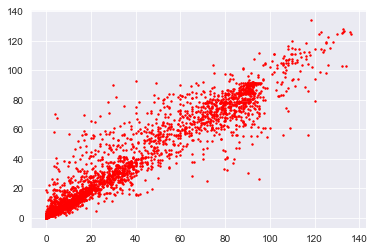

In [254]:
sns.set_style("darkgrid")
plt.scatter(y_test, y_test_pred, s=2, c='r');

## Blending results from different models

#### Separate regression models for Fe-based, Cu-based and Other materials and results blending

We now build separate regression models to predict critical temperature for Fe-based, Cu-based and other materials. Once the independent models are developed, we can blend those results and compare the results with the combined model discussed above.

In [445]:
# separate dataframes
Fe_df = df[df.category == 'Fe-based']
Cu_df = df[df.category == 'Cu-based']
Other_df = df[df.category == 'Other']

In [446]:
# takes dataframe and returns 
# dataset ready for model input
def dataframe_model_input(df):
    y = df.critical_temp
    X = df.drop(columns=['material', 'Fe', 'Cu', 'Other', 'category' , 'critical_temp'], inplace=False)
    # scaling 
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    # PCA
    pca = PCA(n_components=16)
    pca.fit(X)
    X_pca = pca.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.15)
    return X_train, X_test, y_train, y_test

#### a. Fe-based materials

In [450]:
X_train, X_test, y_train, y_test_fe = dataframe_model_input(Fe_df)

C:\Users\nepal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\nepal\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


In [451]:
reg = RandomForestRegressor()

In [252]:
params_grid = {"n_estimators": [100, 120], "max_depth": [None, 21], "max_features": None}
model_fe = GridSearchCV(reg, params_grid, cv=5)

In [253]:
model_fe.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [120, 124], 'max_depth': [19, 21]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [258]:
model_fe.best_params_

{'max_depth': 21, 'n_estimators': 124}

In [257]:
model_fe.best_score_

0.8237803773386917

In [452]:
reg = RandomForestRegressor(n_estimators=100, max_depth=21, max_features=None)

In [453]:
reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=21,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [455]:
# prediction on test data
y_test_pred_fe = reg.predict(X_test)

In [457]:
r2_score(y_test_fe, y_test_pred_fe)

0.8402628036609834

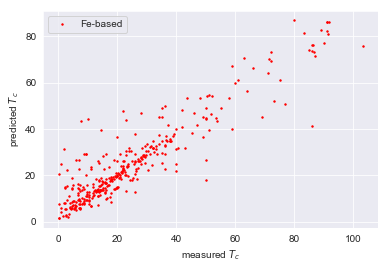

In [458]:
sns.set_style("darkgrid")
plt.scatter(y_test_fe, y_test_pred_fe, s=2, c='r', label='Fe-based');
plt.legend()
plt.xlabel('measured $T_c$')
plt.ylabel('predicted $T_c$');

#### b. Cu-based materials

In [459]:
X_train, X_test, y_train, y_test_cu = dataframe_model_input(Cu_df)

C:\Users\nepal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\nepal\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


In [389]:
reg = RandomForestRegressor()

In [390]:
params_grid = {"n_estimators": [100, 120], "max_depth": [None, 21], "max_features": None}
model_cu = GridSearchCV(reg, params_grid, cv=5)

In [391]:
model_cu.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 120], 'max_depth': [None, 21]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [392]:
model_cu.best_params_

{'max_depth': None, 'n_estimators': 120}

In [394]:
model_fe.best_score_

0.8237803773386917

In [460]:
reg = RandomForestRegressor(n_estimators=120, max_depth=None, max_features=None)

In [461]:
reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [462]:
# prediction on test data
y_test_pred_cu = reg.predict(X_test)

In [463]:
r2_score(y_test_cu, y_test_pred_cu)

0.8346403211016611

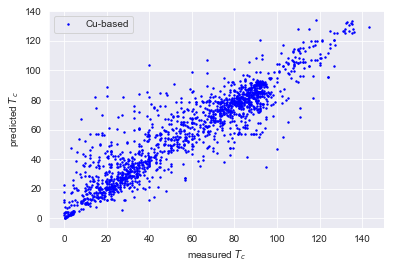

In [464]:
sns.set_style("darkgrid")
plt.scatter(y_test_cu, y_test_pred_cu, s=2, c='b', label='Cu-based');
plt.legend()
plt.xlabel('measured $T_c$')
plt.ylabel('predicted $T_c$');

#### c. Other (rest other than Fe-based and Cu-based) materials

In [465]:
X_train, X_test, y_train, y_test_other = dataframe_model_input(Other_df)

C:\Users\nepal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\nepal\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


In [402]:
reg = RandomForestRegressor()

In [ ]:
params_grid = {"n_estimators": [100, 120], "max_depth": [None, 21], "max_features": None}
model_other = GridSearchCV(reg, params_grid, cv=5)

In [ ]:
model_other.fit(X_train, y_train)

In [ ]:
model_other.best_params_

In [ ]:
model_other.best_score_

In [466]:
reg = RandomForestRegressor(n_estimators=100, max_depth=21, max_features=None)

In [467]:
reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=21,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [468]:
# prediction on test data
y_test_pred_other = reg.predict(X_test)

In [469]:
r2_score(y_test_other, y_test_pred_other)

0.7812915253837792

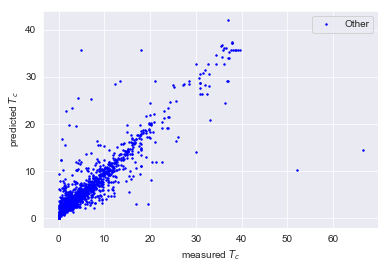

In [471]:
sns.set_style("darkgrid")
plt.scatter(y_test_other, y_test_pred_other, s=2, c='b', label='Other');
plt.legend()
plt.xlabel('measured $T_c$')
plt.ylabel('predicted $T_c$');

## Blending results

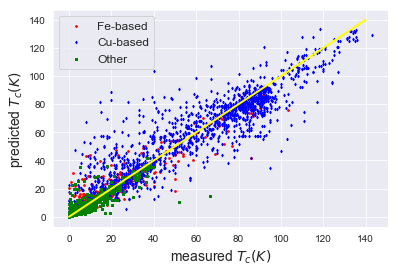

In [493]:
sns.set_style("darkgrid")
plt.scatter(y_test_fe, y_test_pred_fe, s=3, c='r', marker='o', label='Fe-based');
plt.scatter(y_test_cu, y_test_pred_cu, s=3, c='b', marker='d', label='Cu-based');
plt.scatter(y_test_other, y_test_pred_other, s=3, c='g', marker='s', label='Other');
plt.plot([0, 140], [0, 140], c='yellow', linewidth=2)

plt.legend(fontsize='large')
plt.xlabel('measured $T_c(K)$', fontsize=14)
plt.ylabel('predicted $T_c(K)$', fontsize=14);
plt.savefig("reg-predictions.pdf")

### Without features scaling and PCA:

Sine ideally RF perform well even without features scaling and and engineering, which it can intrinsically carry out to some exent, let us first check the performance with the raw data with furhter feature preprocessing. Here we will look for regression model to predict critical temperature.


In [551]:
y = df.critical_temp
X = df.drop(columns=['material', 'Fe', 'Cu', 'Other', 'category' , 'critical_temp'], inplace=False)

In [552]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [553]:
reg = RandomForestRegressor()

In [554]:
# truncated search range after some previous experiments
params_grid = {"n_estimators": [100, 120, 140], "max_depth": [17, 19, None]}
model = GridSearchCV(reg, params_grid, cv=5)

In [555]:
model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 120], 'max_depth': [17, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [556]:
model.best_params_

{'max_depth': 17, 'n_estimators': 120}

In [557]:
model.best_score_

0.9222680267533366

In [558]:
reg = RandomForestRegressor(n_estimators=120, max_depth=17)

In [559]:
reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=19,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [560]:
y_test_pred = reg.predict(X_test)

In [561]:
r2_score(y_test, y_test_pred)

0.928601417632298

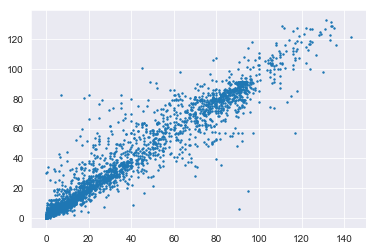

In [562]:
plt.scatter(y_test, y_test_pred, s=2);